PermissionError: [Errno 13] Permission denied: 'C:\\Users\\James\\SkyDrive\\Documents\\HKU\\TechniquesInCompFin\\Arb_32.csv'

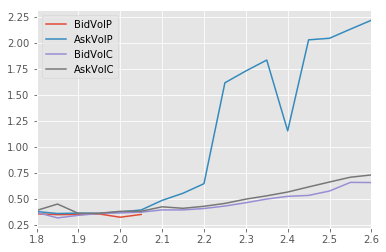

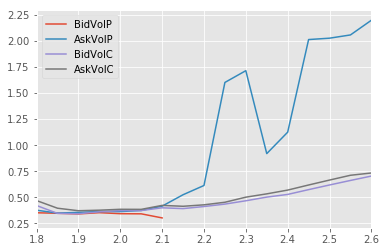

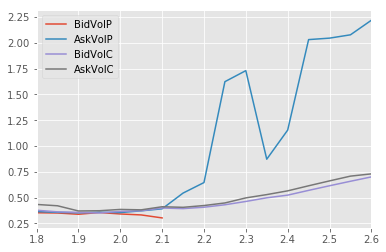

In [67]:
import datetime as dt
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib
matplotlib.style.use('ggplot')

from scipy.stats import norm

def FullBlackScholesCall(S, X, r, t, vol, q):
    d1 = (np.log(S/X)+(r-q+vol**2 / 2)*t)/(vol*t**0.5)
    d2 = d1 - vol * t ** 0.5
    #d1= (np.log(S/X)+(r-q)*t)/(vol * t **0.5)+1/2 * vol * t **0.5
    #d2= (np.log(S/X)+(r-q)*t)/(vol * t **0.5)-1/2 * vol * t **0.5
    
    return S / np.exp(q * t) * norm.cdf(d1) - norm.cdf(d2) * X / np.exp(r * t)

def FullBlackScholesPut(S, X, r, t, vol, q):
    d1 = (np.log(S/X)+(r-q+vol**2 / 2)*t)/(vol*t**0.5)
    d2 = d1 - vol * t ** 0.5
    #d1= (np.log(S/X)+(r-q)*t)/(vol * t **0.5)+1/2 * vol * t **0.5
    #d2= (np.log(S/X)+(r-q)*t)/(vol * t **0.5)-1/2 * vol * t **0.5
    
    return norm.cdf(0-d2) * X / np.exp(r * t) -S / np.exp(q * t) * norm.cdf(0-d1)

def Vega(S, X, r, t, vol, q):
    d1 = (np.log(S/X)+(r-q+vol**2 / 2)*t)/(vol*t**0.5)
    #d1= (np.log(S/X)+(r-q)*t)/(vol * t **0.5)+1/2 * vol * t **0.5

    return S / np.exp(q * t) * t ** 0.5 * norm.pdf(d1)

def ImpliedVolatilityCall(S, X, r, t, C_true, q, sigmaHat):
    tol = 1e-8
    sigmadiff = 1.0
    intI = 1
    iMax = 100

    sigma = sigmaHat

    while (sigmadiff >= tol and intI < iMax):
        if 0 == sigma:
            return np.nan
        C = FullBlackScholesCall(S, X, r, t, sigma, q)
        Cvega = Vega (S, X, r, t, sigma, q)
        if 0 == round(Cvega,10):
            return np.nan
        increment = (C - C_true)/Cvega
        sigma = sigma - increment
        intI=intI+1
        sigmadiff = abs(increment)

    return sigma

def ImpliedVolatilityPut(S, X, r, t, P_true, q, sigmaHat):
    tol = 1e-8
    increment = 1.0
    intI = 1
    iMax = 100

    sigma = sigmaHat

    while (abs(increment) >= tol):
        #if 2.4<X:
            #print(S, X, r, t, P_true, q, sigma, intI, increment)
        if 0 == sigma:
            return np.nan
        P = FullBlackScholesPut(S, X, r, t, sigma, q)
        Pvega = Vega (S, X, r, t, sigma, q)
        if 0 == round(Pvega,10):
            return np.nan
        increment = (P - P_true)/Pvega
        sigma = sigma - increment
        intI=intI+1
        if iMax <= intI:
            return np.nan

    #print(S, X, r, t, P_true, q, sigma, intI, increment, 'return')
    return sigma

def CallFromPut(S, X, r, t, P_true, q):
    return (S / np.exp(q * t) - X / np.exp (r * t) + P_true)

def PutFromCall(S, X, r, t, C_true, q):
    return (X / np.exp (r * t) - S / np.exp(q * t) + C_true)

def main():
    #constants
    directory = "C:\\Users\\James\\SkyDrive\\Documents\\HKU\\TechniquesInCompFin\\"
    r = 0.04
    q = 0.20

    #read instrument data
    securities = pd.read_csv(directory + "instruments.csv", dtype = str)
    securities = securities.set_index('Symbol')
    securities['Expiry'] = pd.to_datetime(securities['Expiry'], errors='coerce')

    #print(securities)

    #read price data
    market_data = pd.read_csv(directory + "marketdata.csv", dtype = str)
    market_data['LocalTime'] = pd.to_datetime(market_data['LocalTime'], errors='coerce')
    market_data = market_data.sort_values('LocalTime')
    
    #clean data by removing records with no bid/ask
    market_data = market_data.loc[market_data['Bid1'] != "0."]
    market_data = market_data.loc[market_data['Ask1'] != "0."]
    market_data['Bid1'] = pd.to_numeric(market_data['Bid1'], errors='coerce')
    market_data['Ask1'] = pd.to_numeric(market_data['Ask1'], errors='coerce')

    # process data into 31, 32 & 33
    data31 = market_data[(market_data['LocalTime'] < dt.datetime(2016, 2, 16, 9, 31, 0, 0))]
    data32 = market_data[(market_data['LocalTime'] < dt.datetime(2016, 2, 16, 9, 32, 0, 0))]
    data33 = market_data[(market_data['LocalTime'] < dt.datetime(2016, 2, 16, 9, 33, 0, 0))]

    # get most recent price for the minute
    data31 = data31.iloc[data31.groupby('Symbol')['LocalTime'].idxmax().values.ravel()]
    data32 = data32.iloc[data32.groupby('Symbol')['LocalTime'].idxmax().values.ravel()]
    data33 = data33.iloc[data33.groupby('Symbol')['LocalTime'].idxmax().values.ravel()]

    # join with instrument details
    data31 = data31.join(securities, on='Symbol')
    data32 = data32.join(securities, on='Symbol')
    data33 = data33.join(securities, on='Symbol')

    #separate into options and etf
    a50etf31 = data31[(data31['Type'] == 'Equity')].reset_index(drop=True) 
    a50etf32 = data32[(data32['Type'] == 'Equity')].reset_index(drop=True) 
    a50etf33 = data33[(data33['Type'] == 'Equity')].reset_index(drop=True) 

    data31 = data31[(data31['Type'] == 'Option')].reset_index(drop=True) 
    data32 = data32[(data32['Type'] == 'Option')].reset_index(drop=True) 
    data33 = data33[(data33['Type'] == 'Option')].reset_index(drop=True) 
    
    #data32.to_csv(directory + "data32.csv", index=False, na_rep='NaN')

    #calculate implied vol
    impliedVolCall = pd.DataFrame(columns=('Strike', 'BidVolC', 'AskVolC'))
    impliedVolPut = pd.DataFrame(columns=('Strike', 'BidVolP', 'AskVolP'))

    arbitrage31 = data31.copy(deep=True)
    arbitrage31['CalcOption'] = np.nan
    arbitrage31['Spot'] = np.nan
    arbitrage32 = data32.copy(deep=True)
    arbitrage32['CalcOption'] = np.nan
    arbitrage32['Spot'] = np.nan
    arbitrage33 = data33.copy(deep=True)
    arbitrage33['CalcOption'] = np.nan
    arbitrage33['Spot'] = np.nan
    
    spot = (float(a50etf31['Bid1'])+float(a50etf31['Ask1'])) /2 
    for index, row in data31.iterrows():
        t = float((row['Expiry'].date() -row['LocalTime'].date()).days)/365
        sigmaHat = np.sqrt(2*abs((np.log(spot/float(row['Strike'])) + (r-q)*t)/t ))
        #print(row)
        #print ((spot, sigmaHat, t, r, q))

        if 'C' == row['OptionType']:
            ImpVolCallBid = ImpliedVolatilityCall(spot, float(row['Strike']), r, t, float(row['Bid1']),q, sigmaHat)
            ImpVolCallAsk = ImpliedVolatilityCall(spot, float(row['Strike']), r, t, float(row['Ask1']),q, sigmaHat)

            series = pd.Series([row['Strike'], ImpVolCallBid, ImpVolCallAsk], index=['Strike', 'BidVolC', 'AskVolC'])
            impliedVolCall.loc[float(row['Strike'])] = series

            #Long Call and short stock so use ask and bid prices
            ArbitragePut = PutFromCall(float(a50etf31['Bid1']), float(row['Strike']), r, t, float(row['Ask1']), q)
            arbitrage31.loc[(arbitrage31.Symbol==row['Symbol']),'CalcOption'] = ArbitragePut
            arbitrage31.loc[(arbitrage31.Symbol==row['Symbol']),'Spot'] = float(a50etf31['Bid1'])

        if 'P' == row['OptionType']:
            ImpVolPutBid = ImpliedVolatilityPut(spot, float(row['Strike']), r, t, float(row['Bid1']),q, sigmaHat)
            ImpVolPutAsk = ImpliedVolatilityPut(spot, float(row['Strike']), r, t, float(row['Ask1']),q, sigmaHat)

            series = pd.Series([row['Strike'], ImpVolPutBid, ImpVolPutAsk], index=['Strike', 'BidVolP', 'AskVolP'])
            impliedVolPut.loc[float(row['Strike'])] = series

            #Long Put and long stock so use ask and ask prices
            ArbitrageCall = CallFromPut(float(a50etf31['Ask1']), float(row['Strike']), r, t, float(row['Ask1']), q)
            arbitrage31.loc[(arbitrage31.Symbol==row['Symbol']),'CalcOption'] = ArbitrageCall
            arbitrage31.loc[(arbitrage31.Symbol==row['Symbol']),'Spot'] = float(a50etf31['Ask1'])

    impliedVol31 = impliedVolPut.join(impliedVolCall.set_index('Strike'), on='Strike', how='left').sort_values('Strike')

    impliedVolCall = pd.DataFrame(columns=('Strike', 'BidVolC', 'AskVolC'))
    impliedVolPut = pd.DataFrame(columns=('Strike', 'BidVolP', 'AskVolP'))

    spot = (float(a50etf32['Bid1'])+float(a50etf32['Ask1'])) /2 
    for index, row in data32.iterrows():
        t = float((row['Expiry'].date() -row['LocalTime'].date()).days)/365
        sigmaHat = np.sqrt(2*abs((np.log(spot/float(row['Strike'])) + (r-q)*t)/t ))

        if 'C' == row['OptionType']:
            ImpVolCallBid = ImpliedVolatilityCall(spot, float(row['Strike']), r, t, float(row['Bid1']),q, sigmaHat)
            ImpVolCallAsk = ImpliedVolatilityCall(spot, float(row['Strike']), r, t, float(row['Ask1']),q, sigmaHat)

            series = pd.Series([row['Strike'], ImpVolCallBid, ImpVolCallAsk], index=['Strike', 'BidVolC', 'AskVolC'])
            impliedVolCall.loc[float(row['Strike'])] = series

            #Long Call and short stock so use ask and bid prices
            ArbitragePut = PutFromCall(float(a50etf32['Bid1']), float(row['Strike']), r, t, float(row['Ask1']), q)
            arbitrage32.loc[(arbitrage32.Symbol==row['Symbol']),'CalcOption'] = ArbitragePut
            arbitrage32.loc[(arbitrage32.Symbol==row['Symbol']),'Spot'] = float(a50etf32['Bid1'])

        if 'P' == row['OptionType']:
            ImpVolPutBid = ImpliedVolatilityPut(spot, float(row['Strike']), r, t, float(row['Bid1']),q, sigmaHat)
            ImpVolPutAsk = ImpliedVolatilityPut(spot, float(row['Strike']), r, t, float(row['Ask1']),q, sigmaHat)

            series = pd.Series([row['Strike'], ImpVolPutBid, ImpVolPutAsk], index=['Strike', 'BidVolP', 'AskVolP'])
            impliedVolPut.loc[float(row['Strike'])] = series

            #Long Put and long stock so use ask and ask prices
            ArbitrageCall = CallFromPut(float(a50etf32['Ask1']), float(row['Strike']), r, t, float(row['Ask1']), q)
            arbitrage32.loc[(arbitrage32.Symbol==row['Symbol']),'CalcOption'] = ArbitrageCall
            arbitrage32.loc[(arbitrage32.Symbol==row['Symbol']),'Spot'] = float(a50etf32['Ask1'])

    impliedVol32 = impliedVolPut.join(impliedVolCall.set_index('Strike'), on='Strike', how='left').sort_values('Strike')

    impliedVolCall = pd.DataFrame(columns=('Strike', 'BidVolC', 'AskVolC'))
    impliedVolPut = pd.DataFrame(columns=('Strike', 'BidVolP', 'AskVolP'))

    spot = (float(a50etf33['Bid1'])+float(a50etf33['Ask1'])) /2 
    for index, row in data33.iterrows():
        t = float((row['Expiry'].date() -row['LocalTime'].date()).days)/365
        sigmaHat = np.sqrt(2*abs((np.log(spot/float(row['Strike'])) + (r-q)*t)/t ))

        if 'C' == row['OptionType']:
            ImpVolCallBid = ImpliedVolatilityCall(spot, float(row['Strike']), r, t, float(row['Bid1']),q, sigmaHat)
            ImpVolCallAsk = ImpliedVolatilityCall(spot, float(row['Strike']), r, t, float(row['Ask1']),q, sigmaHat)

            series = pd.Series([row['Strike'], ImpVolCallBid, ImpVolCallAsk], index=['Strike', 'BidVolC', 'AskVolC'])
            impliedVolCall.loc[float(row['Strike'])] = series

            #Long Call and short stock so use ask and bid prices
            ArbitragePut = PutFromCall(float(a50etf33['Ask1']), float(row['Strike']), r, t, float(row['Ask1']), q)
            arbitrage33.loc[(arbitrage33.Symbol==row['Symbol']),'CalcOption'] = ArbitragePut
            arbitrage33.loc[(arbitrage33.Symbol==row['Symbol']),'Spot'] = float(a50etf33['Ask1'])

        if 'P' == row['OptionType']:

            ImpVolPutBid = ImpliedVolatilityPut(spot, float(row['Strike']), r, t, float(row['Bid1']),q, sigmaHat)
            ImpVolPutAsk = ImpliedVolatilityPut(spot, float(row['Strike']), r, t, float(row['Ask1']),q, sigmaHat)

            series = pd.Series([row['Strike'], ImpVolPutBid, ImpVolPutAsk], index=['Strike', 'BidVolP', 'AskVolP'])
            impliedVolPut.loc[float(row['Strike'])] = series

            #Long Put and long stock so use ask and ask prices
            ArbitrageCall = CallFromPut(float(a50etf33['Bid1']), float(row['Strike']), r, t, float(row['Ask1']), q)
            arbitrage33.loc[(arbitrage33.Symbol==row['Symbol']),'CalcOption'] = ArbitrageCall
            arbitrage33.loc[(arbitrage33.Symbol==row['Symbol']),'Spot'] = float(a50etf33['Bid1'])

    impliedVol33 = impliedVolPut.join(impliedVolCall.set_index('Strike'), on='Strike', how='left').sort_values('Strike')

    #save results to \31.csv", \32.csv", and \33.csv"
    impliedVol31.to_csv(directory + "31.csv", index=False, na_rep='NaN')
    impliedVol32.to_csv(directory + "32.csv", index=False, na_rep='NaN')
    impliedVol33.to_csv(directory + "33.csv", index=False, na_rep='NaN')

    #create graphs (on iPython)
    impliedVol31.plot()
    impliedVol32.plot()
    impliedVol33.plot()

    #check for arbitrage

    arb31_P = arbitrage31.loc[(arbitrage31.OptionType=='P')].add_suffix('_P')
    arb31_C = arbitrage31.loc[(arbitrage31.OptionType=='C')].add_suffix('_C')
    arbitrage31 = arb31_C.join(arb31_P.set_index('Strike_P'), on='Strike_C', how='left').sort_values('Strike_C')
    arbitrage31 = arbitrage31.loc[(arbitrage31.CalcOption_P<arbitrage31.Bid1_C) | (arbitrage31.CalcOption_C<arbitrage31.Bid1_P)]
    arbitrage31['ProfitBuyC']=  (arbitrage31['Bid1_P'] - arbitrage31['CalcOption_C']) * 10000-3.3*3
    arbitrage31['ProfitBuyP']=  (arbitrage31['Bid1_C'] - arbitrage31['CalcOption_P']) * 10000-3.3*3
    
    arbitrage31.to_csv(directory + "Arb_31.csv", index=False, na_rep='NaN')

    arb32_P = arbitrage32.loc[(arbitrage32.OptionType=='P')].add_suffix('_P')
    arb32_C = arbitrage32.loc[(arbitrage32.OptionType=='C')].add_suffix('_C')
    arbitrage32 = arb32_C.join(arb32_P.set_index('Strike_P'), on='Strike_C', how='left').sort_values('Strike_C')
    arbitrage32 = arbitrage32.loc[(arbitrage32.CalcOption_P<arbitrage32.Bid1_C) | (arbitrage32.CalcOption_C<arbitrage32.Bid1_P)]
    arbitrage32['ProfitBuyC']=  (arbitrage32['Bid1_P'] - arbitrage32['CalcOption_C']) * 10000-3.3*3
    arbitrage32['ProfitBuyP']=  (arbitrage32['Bid1_C'] - arbitrage32['CalcOption_P']) * 10000-3.3*3
    
    arbitrage32.to_csv(directory + "Arb_32.csv", index=False, na_rep='NaN')
    
    arb33_P = arbitrage33.loc[(arbitrage33.OptionType=='P')].add_suffix('_P')
    arb33_C = arbitrage33.loc[(arbitrage33.OptionType=='C')].add_suffix('_C')
    arbitrage33 = arb33_C.join(arb33_P.set_index('Strike_P'), on='Strike_C', how='left').sort_values('Strike_C')
    arbitrage33 = arbitrage33.loc[(arbitrage33.CalcOption_P<arbitrage33.Bid1_C) | (arbitrage33.CalcOption_C<arbitrage33.Bid1_P)]
    arbitrage33['ProfitBuyC']=  (arbitrage33['Bid1_P'] - arbitrage33['CalcOption_C']) * 10000-3.3*3
    arbitrage33['ProfitBuyP']=  (arbitrage33['Bid1_C'] - arbitrage33['CalcOption_P']) * 10000-3.3*3
    
    arbitrage33.to_csv(directory + "Arb_33.csv", index=False, na_rep='NaN')


main()

